In [ ]:
import logging

import lightning as pl
from lightning.pytorch.loggers.csv_logs import CSVLogger
import torch
from torch.utils.data import DataLoader, Subset

from neural_bandits.bandits.neural_linear_bandit import NeuralLinearBandit
from neural_bandits.benchmark.datasets.statlog import StatlogDataset

from neural_bandits.benchmark.environment import BanditBenchmarkEnvironment
from neural_bandits.benchmark.logger_decorator import OnlineBanditLoggerDecorator

In [ ]:
class Encoder(torch.nn.Module):
    """A simple encoder neural network with 2 hidden layers."""
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int):
        """Initialize the encoder neural network.
        
        Args:
            input_dim: The dimension of the input tensor.
            hidden_dim: The dimension of the hidden tensor.
            output_dim: The dimension of the output tensor.
        """
        super(Encoder, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass of the encoder neural network."""
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
dataset = StatlogDataset()
print(dataset.context_size)
print(len(dataset))

7
58000


In [4]:
train_loader = DataLoader(Subset(dataset, range(5000)), batch_size=32, shuffle=True)
env = BanditBenchmarkEnvironment(train_loader)
bandit_module = NeuralLinearBandit(
        encoder = Encoder(
            input_dim = dataset.context_size * dataset.num_actions,
            hidden_dim = 64,
            output_dim = 32
        ),
        n_encoder_input_size = dataset.context_size * dataset.num_actions,
        n_embedding_size = 32,
)

logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.FATAL)
logger = OnlineBanditLoggerDecorator(CSVLogger("logs", name="neural_linear_bandit", flush_logs_every_n_steps=100))

In [ ]:
for contextualized_actions in env:
    chosen_actions, _ = bandit_module.forward(contextualized_actions)

    trainer = pl.Trainer(max_epochs=1, logger=logger, log_every_n_steps=1, enable_progress_bar=False, enable_model_summary=False, enable_checkpointing=False)
    feedback = env.get_feedback(chosen_actions)
    batch_regret = env.compute_regret(chosen_actions)
    logger.pre_training_log({"regret": batch_regret.sum().item()})

    batch_dataloader = DataLoader(feedback, batch_size=1)
    trainer.fit(bandit_module, batch_dataloader)

Step: 27 {'training_run': 0, 'reward': 0.0, 'epoch': 0}'regret': 30.0}

c:\Users\Philipp\miniconda3\envs\neural_bandits\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Step: 31 {'training_run': 1, 'reward': 1.0, 'epoch': 0, 'regret': 7.0}1193, 'epoch': 0}

C:\Users\Philipp\2_uni\wise2425\MAB\neural-bandits\src\neural_bandits\bandits\neural_linear_bandit.py:319: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return torch.nn.functional.mse_loss(y_pred, y)
c:\Users\Philipp\miniconda3\envs\neural_bandits\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:654: Checkpoint directory c:\Users\Philipp\2_uni\wise2425\MAB\neural-bandits\examples\neural_linear_bandit\version_0\checkpoints exists and is not empty.


Step: 4843 {'training_run': 156, 'reward': 0.0, 'epoch': 0} 'regret': 2.0}1183, 'epoch': 0}

In [6]:
# load metrics from the logger and plot
import pandas as pd
import numpy as np

metrics_csv = logger._logger_wrappee.log_dir + "/metrics.csv"
print(metrics_csv)
metrics = pd.read_csv(metrics_csv)
cumulative_reward = np.cumsum(metrics["reward"][:5000])
cumulative_regret = np.cumsum(metrics["regret"][:5000].dropna())

logs\neural_linear_bandit\version_0/metrics.csv


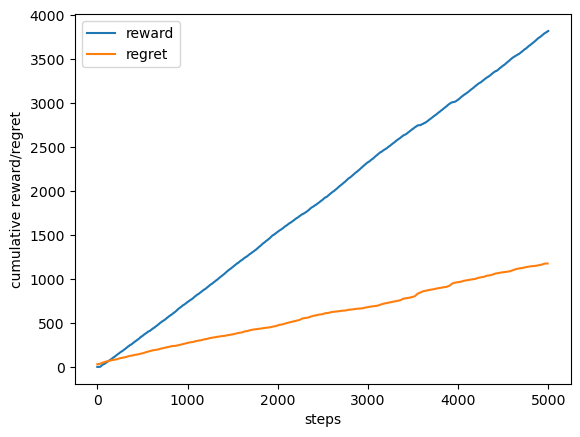

In [7]:
import matplotlib.pyplot as plt
plt.plot(cumulative_reward, label="reward")
plt.plot(cumulative_regret, label="regret")
plt.xlabel("steps")
plt.ylabel("cumulative reward/regret")
plt.legend()
plt.show()

In [8]:
# average reward
print(sum(metrics["reward"][:100]) / 100)
print(sum(metrics["reward"][:1000]) / 1000)
print(sum(metrics["reward"][:10000]) / 10000)
if "regret" in metrics:
    print(sum(metrics["regret"][:100].dropna()) / 100)
    print(sum(metrics["regret"][:1000].dropna()) / 1000)
    print(sum(metrics["regret"][:10000].dropna()) / 10000)

0.5
0.737
0.3823
0.61
0.269
0.1177


In [9]:
metrics

,epoch,nn_loss,regret,reward,step,training_run
0,0,NaN,30.0,0.0,0,0
1,0,NaN,NaN,0.0,1,0
2,0,NaN,NaN,0.0,2,0
3,0,NaN,NaN,0.0,3,0
4,0,NaN,NaN,0.0,4,0
...,...,...,...,...,...,...
4995,0,NaN,NaN,1.0,4839,156
4996,0,NaN,NaN,1.0,4840,156
4997,0,NaN,NaN,1.0,4841,156
4998,0,NaN,NaN,1.0,4842,156


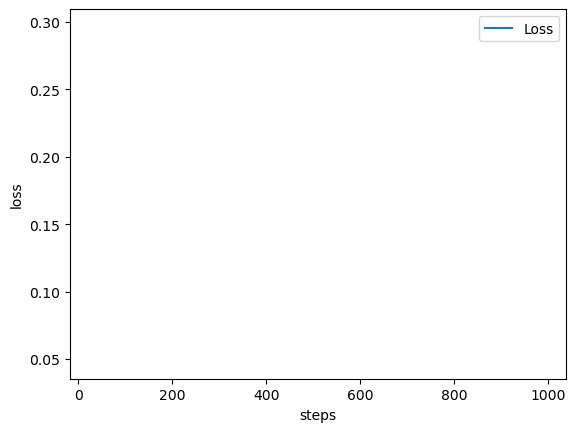

In [10]:
plt.plot(metrics["nn_loss"][:1000], label='Loss')
plt.xlabel("steps")
plt.ylabel("loss")
plt.legend()
plt.show()